## 0. Install and Import Dependencies

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

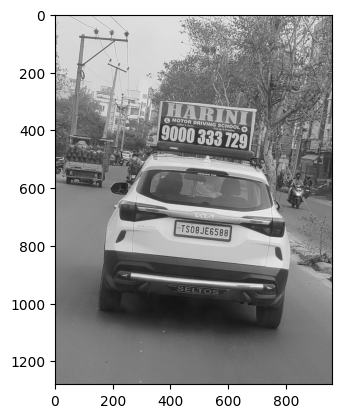

In [2]:
img = cv2.imread('image5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

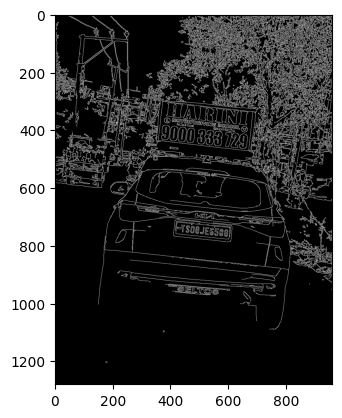

In [3]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [4]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [5]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [6]:
location

array([[[414, 714]],

       [[412, 768]],

       [[607, 783]],

       [[608, 731]]], dtype=int32)

In [7]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

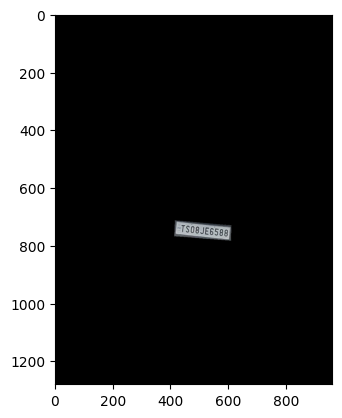

In [8]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [9]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

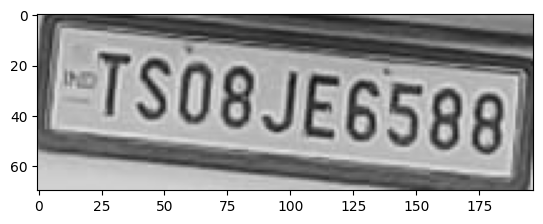

In [10]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [11]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
text = ""

for i in result:
    text += i[1]

if "_" in text:
    text = text.replace("_", "")
if " " in text:
    text=text.replace(" ","")
text=text.upper()
print(text)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


TS08JE6588


## 5. Render Result

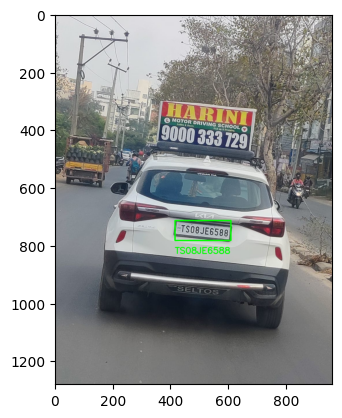

In [12]:
#text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## 6. Removing spaces

In [13]:
x=text.split(" ")
text="".join(x)
print(y)
#Original data is stored in the form of dictionary
data={
    "H982FKL":"Porsche 928",
    "TS08JE6588":"Kia seltos"
}
print(data[text])

[414 415 416 ... 605 606 607]
Kia seltos


## 7.Azure Custom Vision Api Interaction

In [16]:
import requests

# API endpoint and details for image file
endpoint_image = "https://cars7722-prediction.cognitiveservices.azure.com/customvision/v3.0/Prediction/eb8bd9ca-ab07-487f-839a-3d716927b4c8/classify/iterations/Iteration2/image"
prediction_key = "fd0e18db3f604ecea766c8f4d029f729"

# Set headers
headers_image = {
    "Prediction-Key": prediction_key,
    "Content-Type": "application/octet-stream",
}

# Replace with the path to the image file you want to analyze
image_path = r"image5.jpg"

# Read the image file as bytes
image_data = open(image_path, "rb").read()

# Make the prediction request for image file
response_image = requests.post(endpoint_image, headers=headers_image, data=image_data)

# Handle the response
if response_image.status_code == 200:
    results_image = response_image.json()
    # Process the results as needed
    highest_prediction_image = max(results_image['predictions'], key=lambda x: x['probability'])
    print(f"The highest probability prediction is: {highest_prediction_image['tagName']} with probability {highest_prediction_image['probability']:.2%}")
    if data[text] == highest_prediction_image['tagName']:
        print("This is an Original Vehicle")
    else:
        print("This is a Tampered/Fake Number plate")
else:
    print(f"Prediction failed with status code {response_image.status_code}")
    print(response_image.text)


{'id': '85076dcb-512c-4465-b8d0-c4d8e7041880', 'project': 'eb8bd9ca-ab07-487f-839a-3d716927b4c8', 'iteration': '56e9f221-3a81-4fc9-9398-e364e0576478', 'created': '2024-01-28T06:40:11.958Z', 'predictions': [{'probability': 0.8934284, 'tagId': '620f9d3e-b5b1-46b0-a40f-8cbcd30f579d', 'tagName': 'Kia seltos'}, {'probability': 0.10443711, 'tagId': 'ddc65ae2-9111-46a3-939c-3f515e7b10d5', 'tagName': 'xl6'}, {'probability': 0.001713797, 'tagId': '251a0296-7f6a-42a2-862e-c5a55f6425cb', 'tagName': 'Porsche 928'}, {'probability': 0.00042066947, 'tagId': '40fcc67c-22d9-434d-b528-db3584768121', 'tagName': 'harrier'}]}
